In [1]:
pip install pytorch-gradcam

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import PIL
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import models
from torchvision.utils import make_grid, save_image
import cv2
import numpy as np
import gradcam
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np
import torch
from torchvision import transforms
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from matplotlib import pyplot as plt
from PIL import Image



/home/magali/miniconda3/envs/cv4e_env_new/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import yaml


Load pretrained model

In [ ]:
os.chdir('/home/magali/ct_classifier/ct_classifier')
from train import load_model
from train import create_dataloader
from dataset import CTDataset

config = '/home/magali/ct_classifier/configs/exp_resnet18_sex.yaml'
split = 'val'

# load config
print(f'Using config "{config}"')
cfg = yaml.safe_load(open(config, 'r'))


# setup entities
dl_val = create_dataloader(cfg, split='val')

# load model
model = load_model(cfg)[0]

device = cfg['device']
model.to(device)



In [5]:
dataset = CTDataset(cfg, split='val')  # Assuming split doesn't matter for just getting transform


val number of images 1540 labels 1540 images covered 1540


In [ ]:
model_weights_path = '../best_model.pt'
model.load_state_dict(torch.load(model_weights_path))
model.eval()

In [27]:
img = Image.open('/home/magali/CV4Ecology-summer-school/PrototypeCroppedImages/PrototypeCroppedImages_Sex_Val/1123_cropped.jpg').convert('RGB')
# Resize the image
img_resized = img.resize((224, 224))
input_tensor = dataset.transform(img_resized).unsqueeze(0)
print(img_resized.size)

(224, 224)


In [28]:
# 1. Select the target layer
target_layer = model.feature_extractor.layer4[1].conv2

In [29]:
print(model)

CustomResNet18(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [30]:
import inspect
from gradcam import GradCAM

print(inspect.signature(GradCAM.__init__))

(self, arch: torch.nn.modules.module.Module, target_layer: torch.nn.modules.module.Module)


In [31]:
# 2. Initialize Grad-CAM
cam = GradCAM(arch=model, target_layer=target_layer)

In [32]:
input_tensor = input_tensor.cuda()
mask, logit = cam(input_tensor, class_idx=None)

/home/magali/miniconda3/envs/cv4e_env_new/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/magali/miniconda3/envs/cv4e_env_new/lib/python3.9/site-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [33]:
# 3. Get mask and logit
mask, logit = cam(input_tensor, class_idx=None)  # Class idx None to take the class with highest score
heatmap, result = visualize_cam(mask, input_tensor)


In [38]:
# Assuming img is your tensor with shape (3, 224, 224)
#img_to_display = np.transpose(img_resized, (0, 2, 1))
#print(img_to_display.shape)

(224, 3, 224)


In [39]:
heatmap_single_channel = heatmap[0, :, :]  # take the first channel

# Convert PyTorch tensor to numpy array
result_np = result.cpu().numpy()
result_np = np.transpose(result_np, (1, 2, 0))

# Rescale and convert data type
result_np = (result_np * 255).astype(np.uint8)



In [40]:
print(result_np.shape)
#print(img_to_display.shape)

(224, 224, 3)
(224, 3, 224)


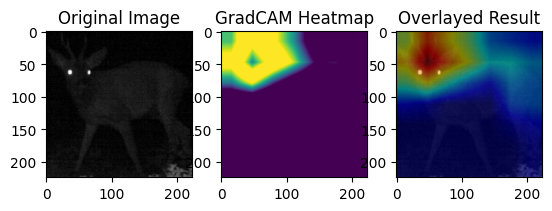

In [41]:
# 4. Display results
fig, axarr = plt.subplots(nrows=1, ncols=3)
axarr[0].imshow(img_resized)
axarr[0].title.set_text('Original Image')

#axarr[1].imshow(heatmap)
#axarr[1].title.set_text('GradCAM Heatmap')
axarr[1].imshow(heatmap_single_channel, cmap='viridis')  # 'viridis' is a popular colormap for heatmaps
axarr[1].title.set_text('GradCAM Heatmap')

#axarr[2].imshow(result)
#axarr[2].title.set_text('Overlayed Result')
axarr[2].imshow(result_np)
axarr[2].title.set_text('Overlayed Result')

plt.show()

GradCAM (Gradient-weighted Class Activation Mapping) is a technique to visualize the "important" regions of an input image as perceived by a particular convolutional neural network (CNN) for a given classification task.

GradCAM Heatmap:

This heatmap is produced directly by the GradCAM method. It shows the regions of the image that influenced the model's decision most significantly. The hotter (brighter) areas represent regions with more influence, while the cooler (darker) areas represent regions with less influence.
The heatmap is often a single-channel image (grayscale), where pixel intensities range from 0 (least influence) to some maximum value (most influence).
Visualization tools (like imshow) can use colormaps (e.g., 'viridis' or 'jet') to display the grayscale heatmap in more visually appealing colors.
Overlayed Result:

This is a visual representation that combines the original input image with the GradCAM heatmap.
The purpose of this overlay is to provide context. By overlaying the heatmap onto the original image, you can see exactly which parts (e.g., features, objects) of the original image were deemed influential by the model.
The overlay is typically created by taking a weighted sum of the original image and a colorized version of the heatmap. This produces an RGB image where the "hot" areas of the heatmap are superimposed onto the original image, allowing you to see both the image content and the regions of interest simultaneously.
In summary:

The GradCAM heatmap gives you a raw view of which regions the model found most influential.
The overlayed result provides context by combining the heatmap with the original image, making it easier to interpret the model's focus in the context of the actual image content.
